# Exploratory Data Analysis

In [149]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from geodatasets import get_path
from matplotlib.patches import Circle


In [134]:
df = pd.read_csv("DATA/global_climate_events_economic_impact_2020_2025.csv")

#drop latitude and longitude columns since we are not using those
df = df.drop(columns=['latitude', 'longitude'])

### Removing Columns
We removed the latitude and longitude columns since our focus is on country-level and event characteristics, not precise locations. Including coordinates wouldn’t improve prediction accuracy and could add noise, as geographic effects are already represented by the country variable.

In [135]:
# dataset information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   event_id                       3000 non-null   object 
 1   date                           3000 non-null   object 
 2   year                           3000 non-null   int64  
 3   month                          3000 non-null   int64  
 4   country                        3000 non-null   object 
 5   event_type                     3000 non-null   object 
 6   severity                       3000 non-null   int64  
 7   duration_days                  3000 non-null   int64  
 8   affected_population            3000 non-null   int64  
 9   deaths                         3000 non-null   int64  
 10  injuries                       3000 non-null   int64  
 11  economic_impact_million_usd    3000 non-null   float64
 12  infrastructure_damage_score    3000 non-null   f

In [136]:
# different types of variables
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
temporal_columns = ['date', 'year', 'month'] 
quantitative_columns = [col for col in df.columns if col not in categorical_columns + temporal_columns]

print("Categorical Variables:", categorical_columns)
print("Temporal Variables:", temporal_columns)
print("Quantitative Variables:", quantitative_columns)

Categorical Variables: ['event_id', 'date', 'country', 'event_type']
Temporal Variables: ['date', 'year', 'month']
Quantitative Variables: ['severity', 'duration_days', 'affected_population', 'deaths', 'injuries', 'economic_impact_million_usd', 'infrastructure_damage_score', 'response_time_hours', 'international_aid_million_usd', 'total_casualties', 'impact_per_capita', 'aid_percentage']


In [137]:
print("\nNumeric Summary")
print(df.describe())


Numeric Summary
              year        month     severity  duration_days  \
count  3000.000000  3000.000000  3000.000000    3000.000000   
mean   2022.401667     6.260333     3.786333       8.783000   
std       1.653857     3.367146     2.005165      14.714508   
min    2020.000000     1.000000     1.000000       0.000000   
25%    2021.000000     3.000000     2.000000       1.000000   
50%    2022.000000     6.000000     4.000000       2.000000   
75%    2024.000000     9.000000     5.000000       9.000000   
max    2025.000000    12.000000     9.000000     115.000000   

       affected_population       deaths     injuries  \
count         3.000000e+03  3000.000000  3000.000000   
mean          8.685505e+05     4.615000    39.228333   
std           3.009690e+06    11.021491    78.812194   
min           6.220000e+02     0.000000     0.000000   
25%           5.451775e+04     1.000000    10.000000   
50%           1.784770e+05     2.000000    18.000000   
75%           6.082012e

In [138]:
# missing values
print("Missing Values Per Column")
print(df.isnull().sum())

Missing Values Per Column
event_id                         0
date                             0
year                             0
month                            0
country                          0
event_type                       0
severity                         0
duration_days                    0
affected_population              0
deaths                           0
injuries                         0
economic_impact_million_usd      0
infrastructure_damage_score      0
response_time_hours              0
international_aid_million_usd    0
total_casualties                 0
impact_per_capita                0
aid_percentage                   0
dtype: int64


In [139]:
# duplicate entries
print("Duplicate Entries")
duplicates = df[df.duplicated()]
print("Number of duplicate entries:", len(duplicates))
if len(duplicates) > 0:
    print("\nSample duplicate rows:\n", duplicates.head())

Duplicate Entries
Number of duplicate entries: 0


In [140]:
# unique values per column
print("\nUnique Values Per Column")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")



Unique Values Per Column
event_id: 3000 unique values
date: 1596 unique values
year: 6 unique values
month: 12 unique values
country: 51 unique values
event_type: 12 unique values
severity: 9 unique values
duration_days: 88 unique values
affected_population: 2994 unique values
deaths: 79 unique values
injuries: 268 unique values
economic_impact_million_usd: 504 unique values
infrastructure_damage_score: 483 unique values
response_time_hours: 54 unique values
international_aid_million_usd: 3 unique values
total_casualties: 270 unique values
impact_per_capita: 791 unique values
aid_percentage: 3 unique values


In [141]:
event_summary = df.groupby('event_type').agg({
    'total_casualties': 'sum',
    'deaths': 'sum',
    'injuries': 'sum',
    'affected_population': 'sum',
    'economic_impact_million_usd': 'sum',
    'infrastructure_damage_score': 'mean',
    'duration_days': 'mean',
    'response_time_hours': 'mean',
    'international_aid_million_usd': 'sum',
    'impact_per_capita': 'mean',
    'aid_percentage': 'mean'
}).sort_values(by='total_casualties', ascending=False)

print(event_summary)

                   total_casualties  deaths  injuries  affected_population  \
event_type                                                                   
Heatwave                      16221    1959     14262            239579683   
Landslide                     15309    1694     13615            233390778   
Drought                       14850    1756     13094            381163175   
Cold Wave                     13858    1435     12423            190013873   
Tornado                       13852    1372     12480            240413988   
Hailstorm                     13832    1380     12452            232646974   
Wildfire                      13663     979     12684            256387085   
Flood                         13622    1688     11934            220529877   
Earthquake                     4373     451      3922            126158892   
Volcanic Eruption              4347     406      3941            168905256   
Tsunami                        3882     346      3536           

In [142]:
# group by event_type and calculate mean of key metrics
if "event_type" in df.columns:
    grouped_evt = (df
        .groupby("event_type")[["severity","duration_days","affected_population",
                                "economic_impact_million_usd","total_casualties"]]
        .mean()
        .sort_values("economic_impact_million_usd", ascending=False)
        .round(2))
    print("\n Mean metrics by event_type")
    print(grouped_evt.head(10))



 Mean metrics by event_type
            severity  duration_days  affected_population  \
event_type                                                 
Heatwave        4.62          28.29           1019488.01   
Drought         4.51          25.87           1454821.28   
Cold Wave       4.52          28.40            798377.62   
Flood           4.42           5.63            997872.75   
Wildfire        4.48           5.12           1081802.05   
Hurricane       2.58           4.87            651975.46   
Tornado         4.44           1.61           1014405.01   
Landslide       4.53           1.56            848693.74   
Hailstorm       4.40           1.59            938092.64   
Tsunami         2.46           1.63            616048.94   

            economic_impact_million_usd  total_casualties  
event_type                                                 
Heatwave                           9.18             69.03  
Drought                            5.10             56.68  
Cold Wave 

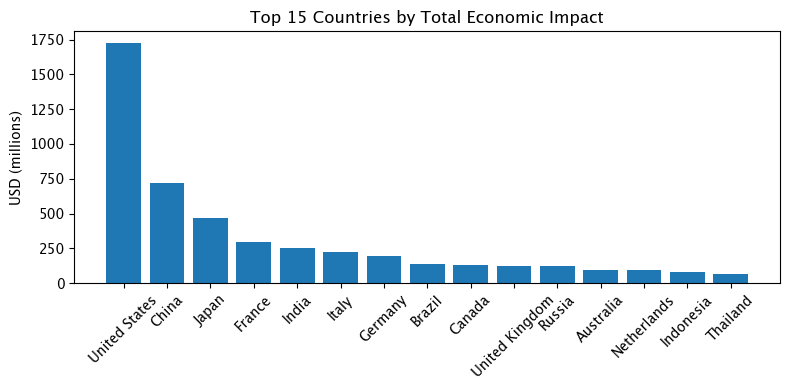

In [143]:
# grouped by country and sum economic impact
if "country" in df.columns and "economic_impact_million_usd" in df.columns:
    by_cty = (df.groupby("country")["economic_impact_million_usd"]
                .sum()
                .sort_values(ascending=False)
                .head(15))

    plt.figure(figsize=(8,4))
    plt.bar(by_cty.index, by_cty.values)
    plt.title("Top 15 Countries by Total Economic Impact")
    plt.ylabel("USD (millions)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 10 Countries by Average Affected Population

This bar chart shows the top 10 countries by average affected population from climate events between 2020 and 2025.
India and China experience the largest average impact, with populations affected far exceeding other nations. The United States, Indonesia, and Brazil follow but at significantly lower levels, indicating that climate events in South and East Asia tend to affect far larger populations than those in other regions.

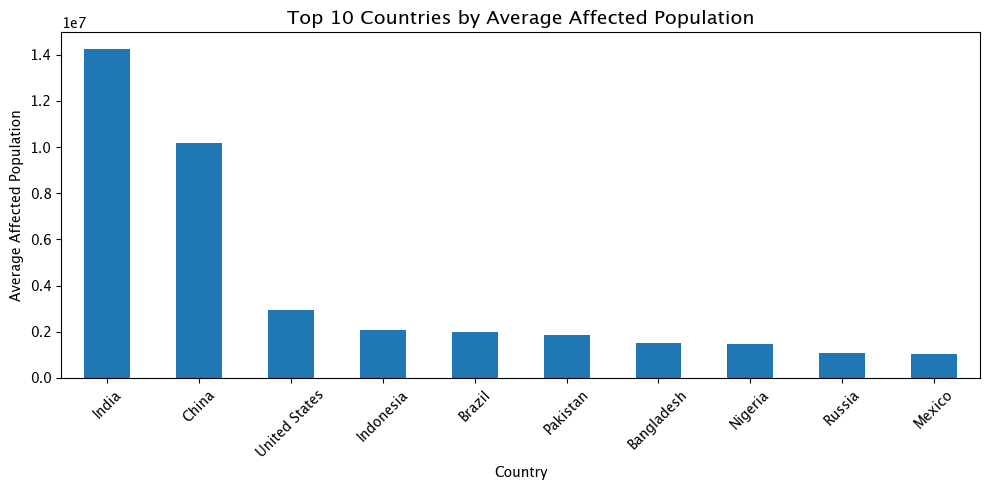

In [144]:
group = df.groupby(['country'])['affected_population'].mean().sort_values(ascending=False).head(10)
group.plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Countries by Average Affected Population', fontsize=14)
plt.ylabel('Average Affected Population')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Top 10 Avergae Economic Impacts per Country
This chart displays the top 10 country–event combinations by average economic impact of climate disasters.
The United States shows the highest economic losses, primarily from heatwaves, followed by China, where cold waves and droughts cause major financial damage. Japan and India also face substantial costs from heatwaves, while the United Kingdom experiences notable economic impacts from droughts. Overall, wealthier nations tend to report higher financial losses per event, reflecting both the scale of infrastructure and the cost of recovery.

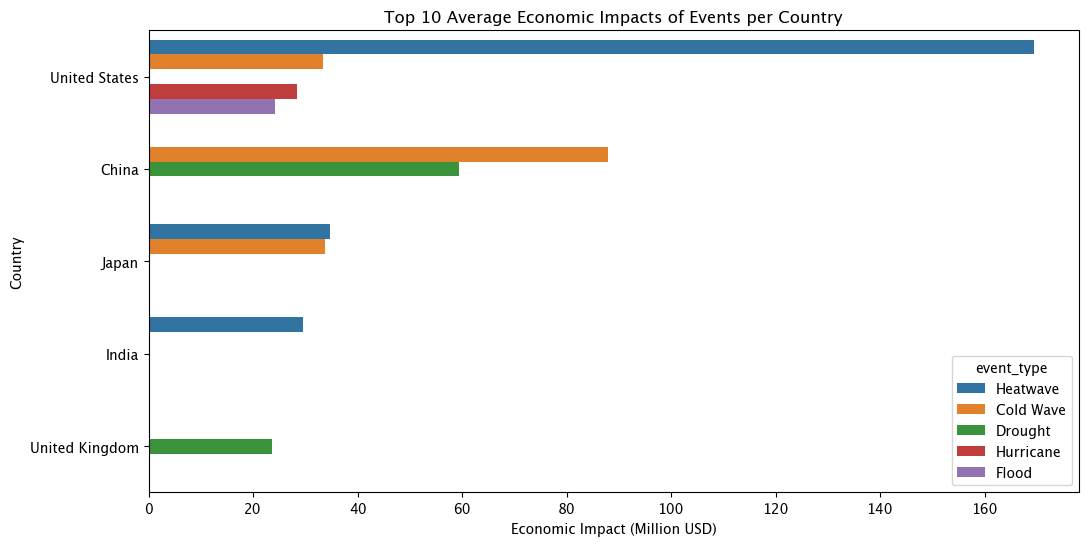

In [145]:
group = (
    df.groupby(['country','event_type'])['economic_impact_million_usd']
      .mean()
      .reset_index()
      .sort_values('economic_impact_million_usd', ascending=False)
      .head(10)
)

plt.figure(figsize=(12,6))
sns.barplot(
    data=group,
    x='economic_impact_million_usd',
    y='country',
    hue='event_type'
)
plt.title('Top 10 Average Economic Impacts of Events per Country')
plt.xlabel('Economic Impact (Million USD)')
plt.ylabel('Country')
plt.show()

### Outlier Analysis Summary

The scatter plots above show the distribution of each numeric variable across all 3,000 climate events. Each point represents a single event, with the x-axis showing its index position in the dataset.

Overall, the plots reveal that most numeric variables are heavily clustered near lower values, with a few points scattered far from the main group, indicating right-skewed distributions and clear outliers.

- Variables like affected_population, economic_impact_million_usd, injuries, deaths, and total_casualties show several extreme points above the main cluster, representing major disasters that impacted large populations or caused high damage.

- international_aid_million_usd and aid_percentage also have occasional extreme points, suggesting that only a few disasters received substantial international financial support.

- duration_days and infrastructure_damage_score show moderate variation with occasional high values, reflecting a mix of short-term and prolonged disasters.

- year, month, latitude, and longitude appear evenly distributed and do not show true outliers since they are fixed or geographic identifiers.

In summary, these scatter plots confirm that the dataset contains realistic, meaningful outliers corresponding to rare but severe natural disasters. Most climate events have small-scale impacts, while a small number of extreme events dominate in terms of population affected and economic loss.


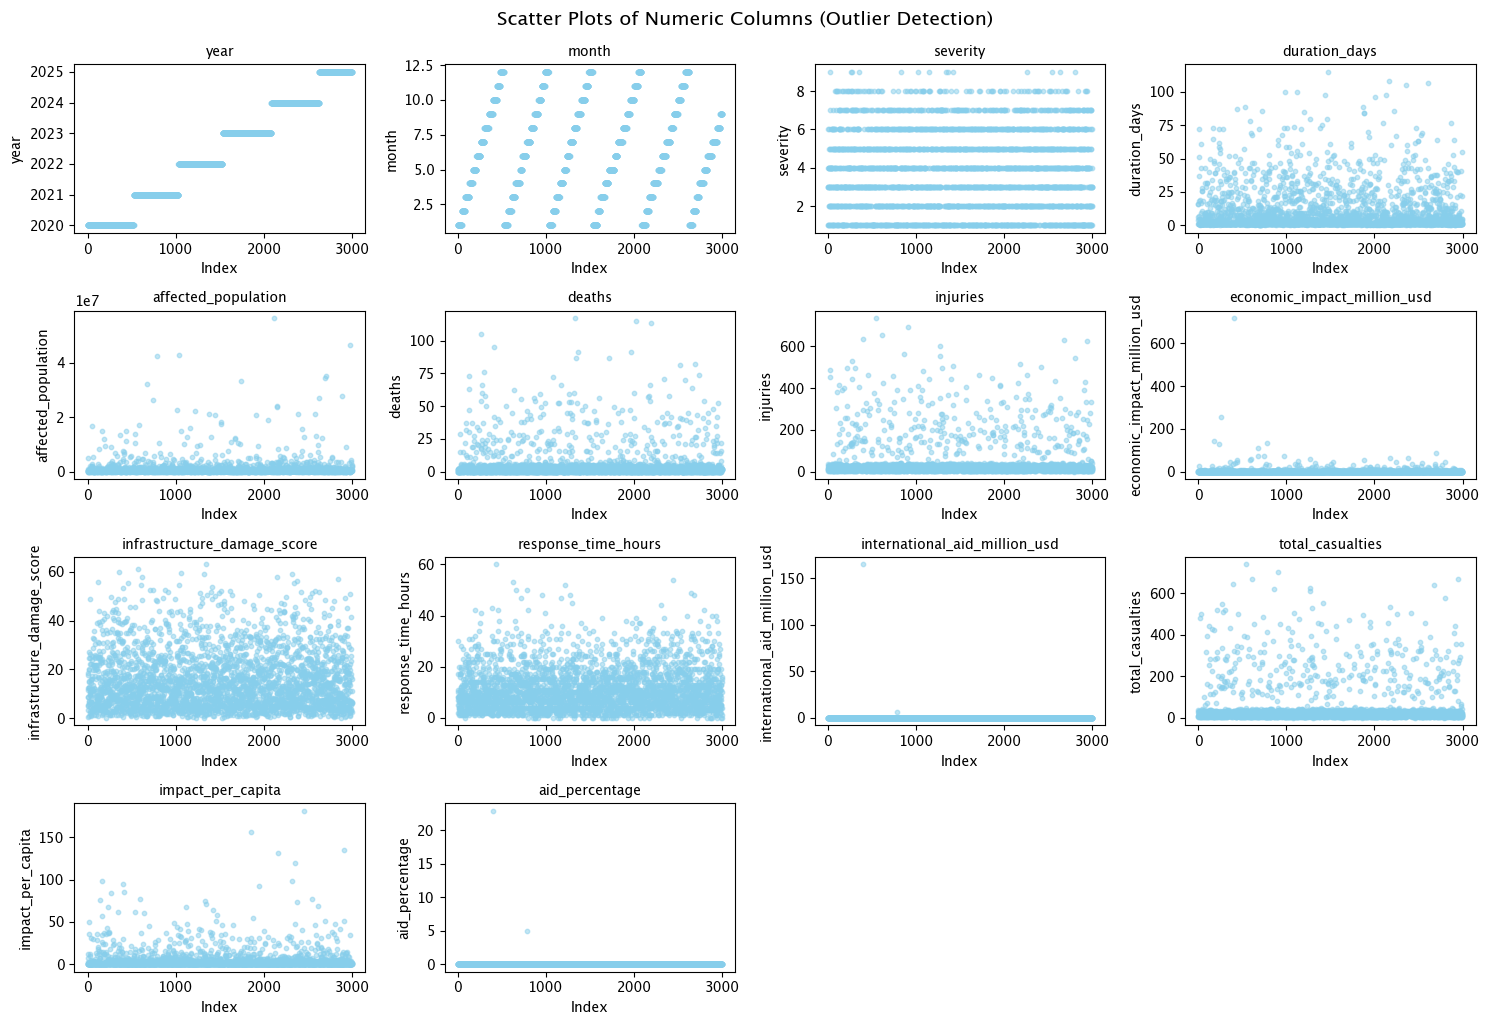

In [146]:
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 10))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols) // 4 + 1, 4, i)
    plt.scatter(range(len(df)), df[col], alpha=0.5, color='skyblue', s=10)
    plt.title(col, fontsize=10)
    plt.xlabel('Index')
    plt.ylabel(col)
    plt.tight_layout()

plt.suptitle("Scatter Plots of Numeric Columns (Outlier Detection)", fontsize=14, y=1.02)
plt.show()

### Correlation Heatmap Summary

The heatmap shows how numeric variables are related in the dataset. Darker red areas indicate strong positive correlations, while blue areas represent weak or negative correlations.

- Most variables have weak to moderate correlations, meaning the dataset contains diverse information without much redundancy.

- Deaths, injuries, and total_casualties are strongly correlated, which is expected since total casualties combine the other two.

- Economic_impact_million_usd is moderately correlated with infrastructure_damage_score and affected_population, showing that events with higher damage and larger populations tend to cause greater economic losses.

- Severity and duration_days have a weak positive correlation, suggesting that longer events are often slightly more severe.

- Impact_per_capita shows mild correlation with both economic impact and affected population, indicating that larger-scale disasters increase individual-level impact.

- International_aid_million_usd and aid_percentage are moderately correlated with other impact measures, implying that higher-impact events typically attract more aid.

Overall, the dataset has a balanced correlation structure with some meaningful relationships but no major multicollinearity concerns.

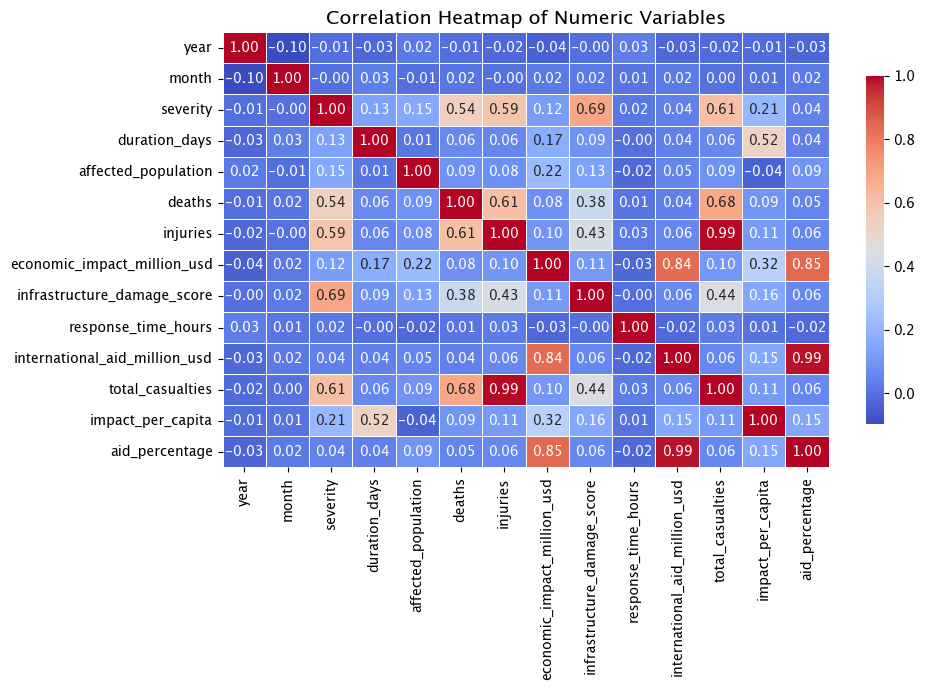

In [154]:
corr = df[numeric_cols].corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(
    corr,
    cmap="coolwarm",
    annot=True,      
    fmt=".2f",
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Heatmap of Numeric Variables", fontsize=14)
plt.tight_layout()
plt.show()